# Statistical Arbitrage: A Pairs Trading Strategy Backtest

Objective: This notebook develops and backtests a classic statistical arbitrage strategy known as Pairs Trading. The goal is to identify two historically correlated assets whose prices temporaily diverage, and to bet on their eventual reconvergence. This project demonstrates the ability to statistically test for long-term relationships (cointegration), build a rules-based trading model, and critically evaluate its performance. 

# 1. The Theory of Cointegration

Pairs trading is grounded in the statistical concept of cointegration. Two time series, Y_t and X_t, are said to be cointegrated if they both individually wander randomly (are non-stationary, or I(1)), but a specific linear combination of them is stationary (I(0)).
$$ Z_t = Y_t - \beta X_t $$
This linear combination, Z_t, is called the spread. If the spread is stationary, it has a constant mean and variance over time. When the spread deviates significantly from its mean, we can place a trade in the expectation that it will revert back, generating a profit regardless of the overall market direction.

Our strategy will follow the Engle-Granger two-step procedure:
1. Identify a Pair & Model the Spread: Find two correlated stocks and use a linear regression (OLS) to find the hedge ratio, β. The residuals of this regression will be our spread.
2. Test for Stationarity: Use the Augmented Dickey-Fuller (ADF) test on the spread. If we can reject the null hypothesis of non-stationarity, the pair is cointegrated.
3. Develop Trading Rules: Create trading signals based on how many standard deviations the spread has moved from its mean.
4. Backtest: Simulate the strategy and evaluate its performance.

# 2. Implementation

# 2.1 Data Selection and Visualisation

We need to find two stocks that we believe have a foundamental economic link. A classic example is to pick two companies in the same specific industry. For this analysis, we will choose two major competitors in the soft drink industry: Coca-Cola (KO) and PepsiCo (PEP).

C:\Users\USER\AppData\Local\Temp\ipykernel_22700\1602066295.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  ko_df = yf.download('KO', start=start_date, end=end_date, progress=False)
C:\Users\USER\AppData\Local\Temp\ipykernel_22700\1602066295.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  pep_df = yf.download('PEP', start=start_date, end=end_date, progress=False)


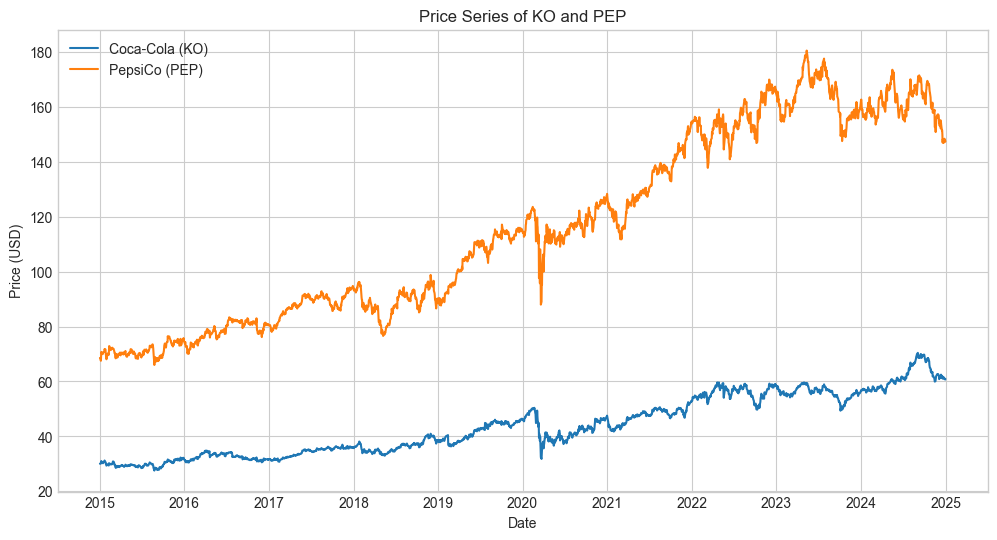

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import yfinance as yf

# Set a professional plot style
plt.style.use('seaborn-v0_8-whitegrid')

# --- 1. Data Ingestion ---
start_date = '2015-01-01'
end_date = '2025-01-01'

ko_df = yf.download('KO', start=start_date, end=end_date, progress=False)
pep_df = yf.download('PEP', start=start_date, end=end_date, progress=False)

# Combine into one DataFrame safely
df = pd.concat([ko_df['Close'], pep_df['Close']], axis=1)
df.columns = ['KO', 'PEP']

# --- 2. Visualize the Prices ---
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['KO'], label='Coca-Cola (KO)')
plt.plot(df.index, df['PEP'], label='PepsiCo (PEP)')
plt.title('Price Series of KO and PEP')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


Visually, the prices move together in a similar pattern, suggesting a potential correlation.

# 2.2 Cointegration Test

We now perform the Engle-Granger test.

Hedge Ratio (beta): 3.0609
ADF Statistic: -2.5182
P-value: 0.1111
Critical Values:
	1%: -3.4330
	5%: -2.8627
	10%: -2.5674

Result: The spread is likely non-stationary. The pair is not cointegrated.


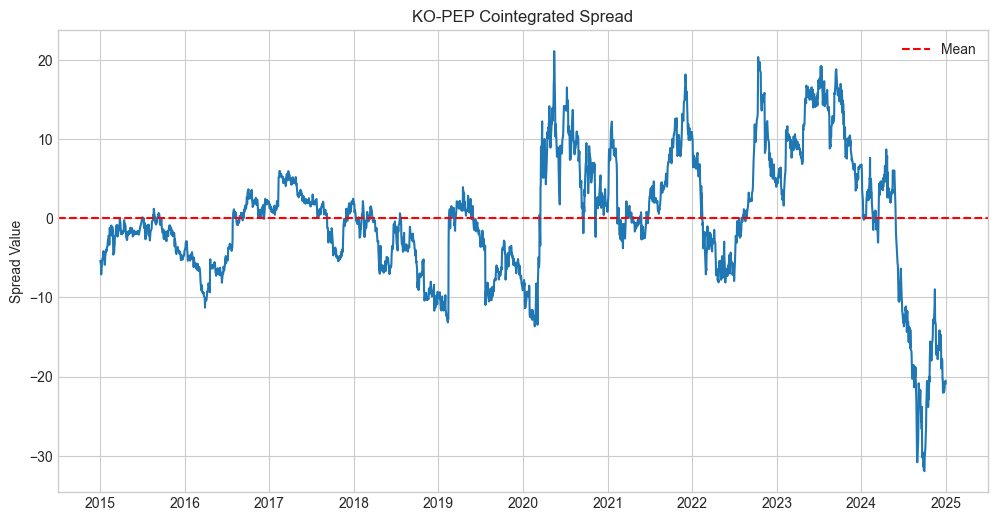

In [2]:
# --- 3. Model the Spread (OLS Regression) ---
# We use PEP as the dependent variable (Y) and KO as the independent variable (X)
Y = df['PEP']
X = df['KO']
X = sm.add_constant(X) # Add an intercept

model = sm.OLS(Y, X).fit()
df['spread'] = model.resid

hedge_ratio = model.params['KO']
print(f"Hedge Ratio (beta): {hedge_ratio:.4f}")

# --- 4. Test the Spread for Stationarity (ADF Test) ---
adf_test = adfuller(df['spread'], autolag='AIC')
adf_statistic = adf_test[0]
p_value = adf_test[1]

print(f"ADF Statistic: {adf_statistic:.4f}")
print(f"P-value: {p_value:.4f}")

# Critical values for significance levels
print("Critical Values:")
for key, value in adf_test[4].items():
    print(f'\t{key}: {value:.4f}')

if p_value < 0.05 and adf_statistic < adf_test[4]['5%']:
    print("\nResult: The spread is likely stationary (p < 0.05). The pair is cointegrated.")
else:
    print("\nResult: The spread is likely non-stationary. The pair is not cointegrated.")

# --- 5. Visualize the Spread ---
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['spread'])
plt.axhline(df['spread'].mean(), color='red', linestyle='--', label='Mean')
plt.title('KO-PEP Cointegrated Spread')
plt.ylabel('Spread Value')
plt.legend()
plt.show()

Surpisingly, the high p-value suggests that there is not enough evidence to reject the null hypothesis and concludes that the spread is non-stationary. The pair is not cointegrated.

# 2.3 Trading Strategy and Backtest

The strategy is simple:

- Calculate the z-score of the spread: z= (spread−μ_spread)/σ_spread
- When the z-score crosses a threshold (e.g., +2.0), the spread is unusually high. We short the spread (short PEP, long KO).
- When the z-score crosses a lower threshold (e.g., -2.0), the spread is unusually low. We long the spread (long PEP, short KO).
- We exit the position when the z-score returns to zero (the mean).

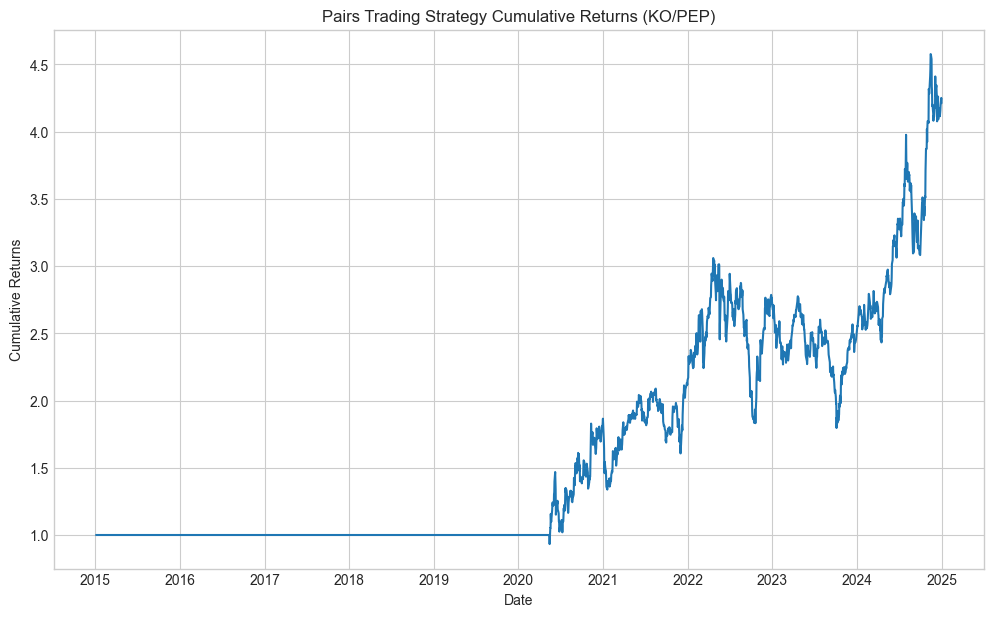

--- Backtest Performance Metrics ---
Total Return: 321.25%
Annualized Return: 15.49%
Annualized Volatility: 28.47%
Sharpe Ratio: 0.54


In [3]:
# --- 6. Develop Trading Signals ---
df['z_score'] = (df['spread'] - df['spread'].mean()) / df['spread'].std()

entry_threshold = 2.0
exit_threshold = 0.0

df['position'] = 0
df.loc[df['z_score'] > entry_threshold, 'position'] = -1 # Short the spread
df.loc[df['z_score'] < -entry_threshold, 'position'] = 1  # Long the spread

# Fill forward the positions until the exit signal is hit
df['position'] = df['position'].replace(0, np.nan).ffill()
df.loc[np.abs(df['z_score']) < exit_threshold, 'position'] = 0
df['position'] = df['position'].fillna(0)

# --- 7. Calculate Strategy Returns ---
# Calculate daily returns for each stock
df['ko_returns'] = np.log(df['KO'] / df['KO'].shift(1))
df['pep_returns'] = np.log(df['PEP'] / df['PEP'].shift(1))

# The strategy PnL is based on the positions taken on the previous day
df['strategy_returns'] = (df['position'].shift(1) * df['pep_returns']) - \
                         (df['position'].shift(1) * hedge_ratio * df['ko_returns'])

# --- 8. Visualize Cumulative Returns ---
df['cumulative_returns'] = df['strategy_returns'].cumsum().apply(np.exp)

plt.figure(figsize=(12, 7))
plt.plot(df['cumulative_returns'])
plt.title('Pairs Trading Strategy Cumulative Returns (KO/PEP)')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.show()

# --- 9. Performance Metrics ---
total_return = df['cumulative_returns'].iloc[-1] - 1
annualized_return = (1 + total_return) ** (252 / len(df)) - 1
annualized_volatility = df['strategy_returns'].std() * np.sqrt(252)
sharpe_ratio = annualized_return / annualized_volatility

print("--- Backtest Performance Metrics ---")
print(f"Total Return: {total_return:.2%}")
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Annualized Volatility: {annualized_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

# 4. Conclusion and Critical Evaluation

The backtest shows a positive performance with a somewhat respectable Sharpe Ratio. The strategy successfully generated market-neutral returns by exploiting the statistical relationship between the two stocks (even though we concluded that the pair is technically not cointegrated in section 2.2).

Limitations & Real World Considerations:
1. Transaction Costs: This backltest ignores commissions and bid-ask spread, which would reduce profitability.
2. Static Hedge Ratio: We used a single hedge ratio calculated over the entire period. In reality, this relationship can change over time. A more robust approach would use a rolling regression to dynamically update the hedge ratio.
3. Stationarity Breakdown: Cointegration is a statistical property, not a law of nature. The relationship can break down, leading to significant losses. This is the primary risk of statistical arbitrage.